# 머신러닝을 이용한 가뭄예측

## 한글데이터 처리를 위한 사전작업

In [1]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc 

get_ipython().run_line_magic("matplotlib", "inline")

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc("font", family=font_name)
else:
    print("Unkown system. sorry~~")

plt.rc('axes', unicode_minus=False)

## 데이터 수집
- 기상자료개방포털(https://data.kma.go.kr)에서 다운로드 
- Feature: 종관기상관측(ASOS)
- Label: 표준강수지수

## 데이터 가공

### 파일 읽기

In [2]:
import pandas as pd
import os

files = os.listdir('../data')
asos_csv_files = [file for file in files if file.startswith("OBS_ASOS_")]

tmp = []
for csv_file in asos_csv_files:
  tmp.append(pd.read_csv('../data/' + csv_file, encoding='euc-kr'))

asos_raw = pd.concat(tmp)
asos_raw.head(2)

지점 지점명          일시  평균기온(°C)  최저기온(°C)  최고기온(°C)  일강수량(mm)  평균 풍속(m/s)  \
0  90  속초  1990-07-01      16.5      14.9      19.5       0.3         2.2   
1  90  속초  1990-07-02      16.2      14.9      17.2      21.3         3.2   

   평균 이슬점온도(°C)  평균 상대습도(%)  평균 현지기압(hPa)  
0          15.2        92.0        1012.8  
1          15.6        95.5        1008.8

- 데이터 가공시 편의를 위해 컬럼이름 정리
- 시간순으로 Sorting
- Index 재 구성

In [3]:
asos = asos_raw[['지점', '일시'
                , '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '평균 현지기압(hPa)'
                , '일강수량(mm)', '평균 풍속(m/s)', '평균 이슬점온도(°C)', '평균 상대습도(%)']].copy()
asos.rename(columns = {
    '평균기온(°C)' : '평균기온',
    '최저기온(°C)' : '최저기온',
    '최고기온(°C)' : '최고기온',
    '평균 현지기압(hPa)' : '기압',
    '일강수량(mm)' : '강수량',
    '평균 풍속(m/s)' : '풍속',
    '평균 이슬점온도(°C)' : '이슬점',
    '평균 상대습도(%)' : '상대습도'
    }, inplace = True)
asos.sort_values('일시' ,inplace=True)
asos.reset_index(drop=True, inplace=True)
asos.head(2)

지점          일시  평균기온  최저기온  최고기온      기압  강수량   풍속   이슬점  상대습도
0   90  1990-07-01  16.5  14.9  19.5  1012.8  0.3  2.2  15.2  92.0
1  277  1990-07-01  18.3  16.5  20.4  1005.4  NaN  4.0  13.9  76.0

#### 결측치를 확인 및 수정
- 결측치를 확인하기 위해 isna() 함수를 이용.
- 강수량의 경우, 비가 내리지 않는날에 대하여 값이 들어오지 않음을 확인 -> 0으로 변경
- 나머지 결측치의 경우, 날씨의 연속성을 고려하여 전일자 데이터로 채움.

In [4]:
asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279791 entries, 0 to 279790
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   지점      279791 non-null  int64  
 1   일시      279791 non-null  object 
 2   평균기온    279734 non-null  float64
 3   최저기온    279784 non-null  float64
 4   최고기온    279783 non-null  float64
 5   기압      279727 non-null  float64
 6   강수량     100734 non-null  float64
 7   풍속      279728 non-null  float64
 8   이슬점     279692 non-null  float64
 9   상대습도    279676 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 21.3+ MB


In [5]:
asos.isna().sum()

지점           0
일시           0
평균기온        57
최저기온         7
최고기온         8
기압          64
강수량     179057
풍속          63
이슬점         99
상대습도       115
dtype: int64

In [6]:
asos['강수량'] = asos['강수량'].fillna(0)
asos = asos.fillna(method='ffill')
asos.isna().sum()

지점      0
일시      0
평균기온    0
최저기온    0
최고기온    0
기압      0
강수량     0
풍속      0
이슬점     0
상대습도    0
dtype: int64

#### ASOS 관측데이터의 6개월 평균값 계산
- Label인 SPI6는 6개월 표준강수지수 이기때문에 두 Feature 값을 모두 6개월 평균 가공

In [7]:
asos['연도'] = asos['일시'].map(lambda x: x.split('-')[0])
asos['월'] = asos['일시'].map(lambda x: x.split('-')[1])
asos_mean = asos.groupby(by=['지점', '연도', '월']).mean()
asos_mean.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 1990 07  21.425806  19.451613  24.387097  1005.903226  8.477419  2.390323   
        08  24.683871  21.616129  28.274194  1006.703226  3.564516  2.209677   

                  이슬점       상대습도  
지점 연도   월                         
90 1990 07  19.938710  91.925806  
        08  21.967742  85.945161

#### 지점별로 6개월씩 rolling 함수를 이용하여 평균값을 연산

In [8]:
asos_pos_list = list(set(asos_mean.index.map(lambda x: x[0])))

tmp = []
for pos in asos_pos_list:
    tmp.append(pd.concat([asos_mean.loc[pos].rolling(window=6).mean().dropna()], keys=[pos], names=['지점']))

asos_mean_6m = pd.concat(tmp)
asos_mean_6m.head()

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
129 1990 12  16.115466  11.923459  21.463136  1013.037455  5.297903  1.957455   
    1991 01  11.696649   7.230448  17.316900  1016.229391  4.033387  1.790789   
         02   7.288411   2.807675  12.876231  1018.844963  2.998671  1.889272   
         03   4.551171  -0.032002  10.230031  1020.095375  1.590678  1.974128   
         04   4.074756  -0.592898   9.807862  1019.495662  1.922901  2.086404   

                   이슬점       상대습도  
지점  연도   월                         
129 1990 12  12.064068  78.620968  
    1991 01   7.369982  76.798387  
         02   2.783077  75.348368  
         03  -0.212855  73.766594  
         04  -0.940256  72.506540

### SPI 데이터 준비
- 6개월의 누적강수량을 분석한 SPI6를 준비

In [9]:
spi_csv_files = [file for file in files if file.startswith("CLM_SPI_")]
spi_csv_files[:2]

tmp = []
for csv_file in spi_csv_files:
  tmp.append(pd.read_csv('../data/' + csv_file, encoding='euc-kr'))

spi_raw = pd.concat(tmp)
spi_raw.head(2)

지점 지점명          일시   SPI6
0  90  속초  1991-01-02  1.457
1  90  속초  1991-01-03  1.478

In [10]:
spi = spi_raw[['지점', '일시', 'SPI6']].copy()
spi.sort_values('일시' ,inplace=True)
spi.reset_index(drop=True, inplace=True)
spi.head(2)

지점          일시   SPI6
0   90  1991-01-02  1.457
1  273  1991-01-02 -0.544

#### 결측치 확인
- 없음

In [11]:
spi.isna().sum()

지점      0
일시      0
SPI6    0
dtype: int64

- 데이터 비교를 위해 일별 계산된 SPI6를 월 평균으로 전환

In [12]:
spi['연도'] = spi['일시'].map(lambda x: x.split('-')[0])
spi['월'] = spi['일시'].map(lambda x: x.split('-')[1])
spi_mean = spi.groupby(by=['지점', '연도', '월']).mean()
spi_mean.head(2)

SPI6
지점 연도   월           
90 1991 01  1.276767
        02  1.782500

#### Label로 가공
-  활용이 쉽도록 표준강수지수에서 약한 가뭄 이상을 1, 정상과 습함을 0으로 정의

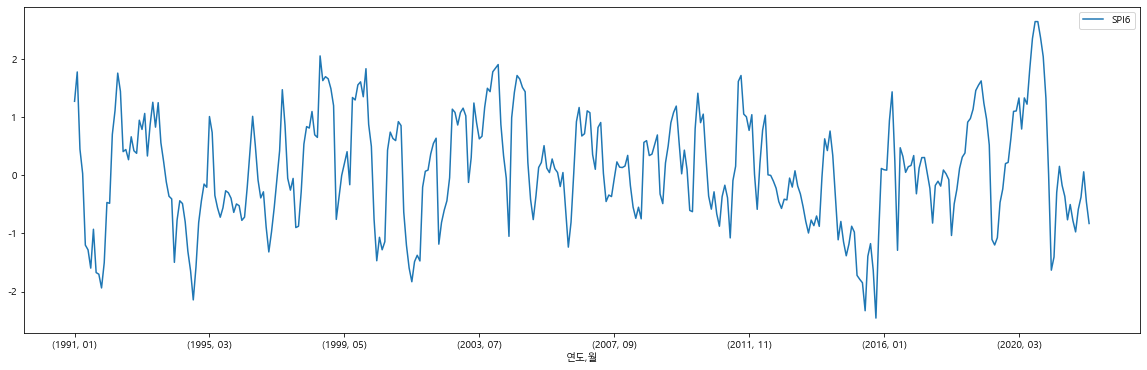

In [13]:
import seaborn as sns

spi_mean.loc[90].plot(figsize=(20, 6));

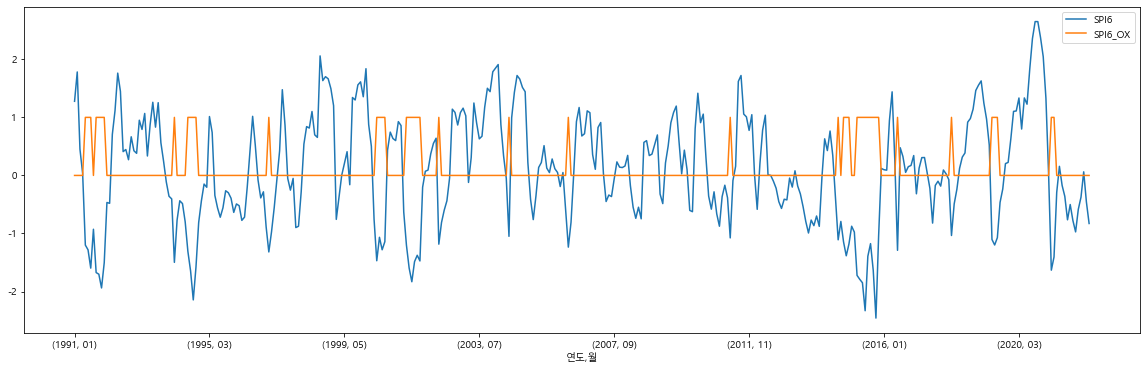

In [14]:
spi_mean['SPI6_OX'] = spi_mean['SPI6'].map(lambda x: 0 if x > -1 else 1)
spi_mean.loc[90].plot.line(figsize=(20, 6));

### 데이터 살펴보기

In [15]:
train_data_raw = pd.merge(asos_mean_6m, spi_mean, on=['지점', '연도', '월']).dropna().sort_index()
train_data_raw.head(2)

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                     
90 1991 01  12.095143  8.574409  16.091595  1016.753387  5.460573  2.996685   
        02   7.983546  4.363387  12.017325  1018.632016  5.017083  3.173643   

                 이슬점       상대습도      SPI6  SPI6_OX  
지점 연도   월                                           
90 1991 01  6.185932  69.743889  1.276767        0  
        02  1.150237  64.995291  1.782500        0

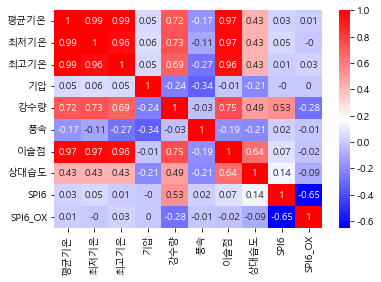

In [16]:
correlation_matrix = train_data_raw.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='bwr');

### 모델 검증

#### SPI6를 0과 1로 나누었을 때

In [17]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re  = recall_score(y_test, pred)
    f1  = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)

    return acc, pre, re, f1, auc

In [18]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)

    print('==> confusion matrix')
    print(confusion)
    print('==============')

    print('Accuracy: {0:.4f}, Precision: {0:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {0:.4f}, AUC: {0:.4f}'.format(re, f1, auc))

In [19]:
from sklearn.model_selection import train_test_split
import numpy as np

# X = train_data_raw.drop(['SPI6', 'SPI6_OX', 'SPI6_5C'], axis=1)
X = train_data_raw.drop(['SPI6', 'SPI6_OX'], axis=1)
y = train_data_raw['SPI6_OX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([5289,  906], dtype=int64))

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

In [21]:
# 모델과 데이터를 주면 성능을 출력하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return get_clf_eval(y_test, pred)

# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [22]:
import time

def call_classification_report(X_train, y_train, X_test, y_test):
    models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
    model_names = ['LinearReg.', 'DecisionTree', 'RandomForest', 'LightGBM']
    
    start_time = time.time()
    results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)

    print('Fit time : ', time.time() - start_time)
    return results

In [23]:
call_classification_report(X_train, y_train, X_test, y_test)

Fit time :  3.3859505653381348


accuracy  precision    recall        f1   roc_auc
LinearReg.    0.897353   0.765152  0.441048  0.559557  0.708782
DecisionTree  0.890252   0.804124  0.340611  0.478528  0.663109
RandomForest  0.907037   0.760736  0.541485  0.632653  0.755970
LightGBM      0.911556   0.727723  0.641921  0.682135  0.800127

In [24]:
import plotly.graph_objects as go

fig = go.Figure()
for col_name in X_train.columns:
    fig.add_trace(go.Box(y=X_train[col_name], name=col_name))

fig.show()

- Feature 값을 확인해본 결과 기압의 데이터가 다른 데이터에 비해 높은것을 확인

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pressure_n = scaler.fit_transform(train_data_raw['기압'].values.reshape(-1, 1))

train_data_raw_n = train_data_raw.drop(columns=['기압'])
train_data_raw_n['기압_N'] = pressure_n
train_data_raw_n.head(2)

평균기온      최저기온       최고기온       강수량        풍속       이슬점  \
지점 연도   월                                                                  
90 1991 01  12.095143  8.574409  16.091595  5.460573  2.996685  6.185932   
        02   7.983546  4.363387  12.017325  5.017083  3.173643  1.150237   

                 상대습도      SPI6  SPI6_OX      기압_N  
지점 연도   월                                           
90 1991 01  69.743889  1.276767        0  0.725466  
        02  64.995291  1.782500        0  0.815133

In [26]:
X = train_data_raw_n.drop(['SPI6', 'SPI6_OX'], axis=1)
y = train_data_raw_n['SPI6_OX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([5289,  906], dtype=int64))

In [27]:
call_classification_report(X_train, y_train, X_test, y_test)

Fit time :  4.402212381362915


accuracy  precision    recall        f1   roc_auc
LinearReg.    0.903163   0.772414  0.489083  0.598930  0.732041
DecisionTree  0.890252   0.804124  0.340611  0.478528  0.663109
RandomForest  0.908974   0.768293  0.550218  0.641221  0.760715
LightGBM      0.916075   0.748744  0.650655  0.696262  0.806388

- 약간의 향상이 있지만 유의미한 수준은 아닌듯

### Outlier 제거
- 몇 가지 데이터를 제거해보았으나 결과가 향상되지 않았음.

In [28]:
fig = go.Figure()
for col_name in X_train.columns:
    fig.add_trace(go.Box(y=X_train[col_name], name=col_name))

fig.show()

In [29]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['SPI6_OX'] ==  1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

#### Oversampling

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=13)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

X_train.shape, y_train.shape, X_train_over.shape, y_train_over.shape

((6195, 8), (6195,), (10578, 8), (10578,))

In [31]:
np.unique(y_train, return_counts=True), np.unique(y_train_over, return_counts=True)

((array([0, 1], dtype=int64), array([5289,  906], dtype=int64)),
 (array([0, 1], dtype=int64), array([5289, 5289], dtype=int64)))

In [32]:
call_classification_report(X_train_over, y_train_over, X_test, y_test)

Fit time :  4.9228432178497314


accuracy  precision    recall        f1   roc_auc
LinearReg.    0.820529   0.446623  0.895197  0.595930  0.851386
DecisionTree  0.712718   0.328571  0.903930  0.481956  0.791738
RandomForest  0.889606   0.596026  0.786026  0.677966  0.846801
LightGBM      0.890897   0.604167  0.759825  0.673114  0.836731

- Oversampling 이전보다 recall은 높아지고 precision은 낮아지는 것을 볼 수 있음. (f1은 약간 차이나게됨)
- precision 이 높다 -> 가뭄이라고 예측한 것 중에 실제 가뭄이였던 비율
- recall 이 높다 -> 실제 가뭄인 데이터중에 가뭄이라고 예측한 것.
- 정상을 가뭄이라고 잘 못 예측하는것 보다, 정상을 가뭄이라고 예측하여 미리 대응하는 것이 나음. 즉, recall을 올려야함.

### 교차검증

#### 과적합인가?

In [38]:
rf_clf.fit(X_train_over, y_train_over)
train_pred = rf_clf.predict(X_train)
test_pred = rf_clf.predict(X_test)

accuracy_score(y_train, train_pred), accuracy_score(y_test, test_pred)

(1.0, 0.8896061975468044)

In [46]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)

cv_accuracy = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_clf.fit(X_train, y_train)
    pred = rf_clf.predict(X_test)
    cv_accuracy.append(accuracy_score(y_test, pred))

cv_accuracy

[0.881859264041317,
 0.8973531310522918,
 0.8967075532601678,
 0.9089735313105229,
 0.8307493540051679]

In [93]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skflod = StratifiedKFold(n_splits=5)

cross_val_score(rf_clf, X, y, scoring=None, cv=skflod)

array([0.87540349, 0.90058102, 0.90187218, 0.90058102, 0.83914729])

In [94]:
from sklearn.model_selection import cross_validate

cross_validate(rf_clf, X, y, scoring=None, cv=skflod, return_train_score=True)

{'fit_time': array([0.71161079, 0.79587412, 0.77093911, 0.57845545, 0.61435771]),
 'score_time': array([0.04986644, 0.05461001, 0.0618341 , 0.03390861, 0.03590417]),
 'test_score': array([0.87540349, 0.90058102, 0.90187218, 0.90058102, 0.83914729]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [95]:
cross_validate(rf_clf, X_train_over, y_train_over, scoring=None, cv=skflod, return_train_score=True)

{'fit_time': array([1.65311527, 1.21839213, 1.05738258, 0.91026068, 0.9507997 ]),
 'score_time': array([0.07496905, 0.05088282, 0.05717421, 0.0948391 , 0.04905868]),
 'test_score': array([0.93100189, 0.93572779, 0.93856333, 0.9286052 , 0.93806147]),
 'train_score': array([1., 1., 1., 1., 1.])}

### 하이퍼파라미터 튜닝

In [92]:
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

params = {
    'max_depth': range(4, 13),
    'n_estimators': [50, 100, 200, 300, 400, 500, 600],
    'min_samples_leaf': [4, 6, 8],
    'min_samples_split': [4, 6, 8],
    'verbose': [1]
}

scoring = ['recall', 'accuracy', 'f1', 'precision']

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1, scoring=scoring, refit="accuracy")
grid_cv.fit(X_train_over, y_train_over)

KeyboardInterrupt: 

In [71]:
grid_cv.best_estimator_

RandomForestClassifier(max_depth=4, min_samples_leaf=8, min_samples_split=8,
                       n_estimators=400, n_jobs=-1, random_state=13, verbose=1)

In [72]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'param_verbose', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision'])

In [81]:
score_df = pd.DataFrame(grid_cv.cv_results_)
score_df[['rank_test_accuracy', 'mean_test_accuracy', 'mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'params', 'param_n_estimators']].sort_values('rank_test_accuracy').head()

rank_test_accuracy  mean_test_accuracy  mean_test_recall  mean_test_f1  \
219                   1            0.872849          0.930989      0.879800   
223                   1            0.872849          0.930989      0.879800   
227                   3            0.871337          0.928909      0.878296   
225                   4            0.871148          0.931178      0.878408   
226                   5            0.870864          0.930989      0.878138   

     mean_test_precision                                             params  \
219             0.834007  {'max_depth': 8, 'min_samples_leaf': 4, 'min_s...   
223             0.834007  {'max_depth': 8, 'min_samples_leaf': 4, 'min_s...   
227             0.832998  {'max_depth': 8, 'min_samples_leaf': 4, 'min_s...   
225             0.831379  {'max_depth': 8, 'min_samples_leaf': 4, 'min_s...   
226             0.831042  {'max_depth': 8, 'min_samples_leaf': 4, 'min_s...   

    param_n_estimators  
219                400  
223                400  
227                400  
225                100  
226                200

In [90]:
score_df.iloc[219]['params']

{'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 400,
 'verbose': 1}

In [85]:
grid_cv.estimator.estimator_params()

TypeError: 'tuple' object is not callable

In [77]:
grid_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'param_verbose', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision'])

In [155]:
from sklearn.metrics import classification_report

best_rf_cls = RandomForestClassifier(random_state=13, n_jobs=-1, max_depth=8, min_samples_leaf=4, min_samples_split=4, n_estimators=400, verbose=1)
best_rf_cls.fit(X_train_over, y_train_over)
pred = best_rf_cls.predict(X_test)

print(classification_report(y_test, pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89      1071
         1.0       0.45      0.67      0.54       194

    accuracy                           0.82      1265
   macro avg       0.69      0.76      0.72      1265
weighted avg       0.86      0.82      0.84      1265



[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished


## 가뭄 예측
- 기상관측값을 실제로 예측할 수 없기때문에 해당 월의 과거 데이터의 평균값을 모델에 넣고 예측해보려고 한다.
- 기간은 2018~2022

### 테스트 데이터 준비

#### 모델의 정확성을 평가할 테스트 데이터 준비

이전 5개월의 월 평균의 합

In [156]:
tmp = []

for pos in asos_pos_list:
    df = asos_mean.loc[pos].rolling(window=5).sum().dropna()
    df.loc[('2022', '06'),:] = np.nan
    tmp.append(pd.concat([df], keys=[pos], names=['지점']).shift(1))

asos_mean_5m = pd.concat(tmp)
asos_mean_5m.tail()

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
114 2022 02  40.729032  18.053656  66.267634  5014.301398  9.634839  4.371828   
         03  18.482366  -5.221582  44.635492  5024.493541  3.761029  4.763733   
         04  11.475914 -13.066743  37.783879  5020.090315  4.599739  5.237926   
         05  18.282581  -7.906743  45.493879  5017.660315  4.459739  5.594593   
         06  36.279355   8.238418  64.897104  5006.082896  4.656513  5.872012   

                   이슬점        상대습도  
지점  연도   월                          
114 2022 02   8.314946  331.277204  
         03 -18.707435  306.726490  
         04 -29.026790  292.432942  
         05 -27.550123  275.442942  
         06 -13.937220  264.662296

최근 20년간 월 평균

In [157]:
asos_mean_sort_month = asos_mean.swaplevel().sort_index()

tmp = []

for idx in list(set(asos_mean_sort_month.index.droplevel(2))):
    df = asos_mean_sort_month.loc[idx].rolling(window=20).mean().dropna()
    df.loc[str(int(df.index.max()) + 1)] = np.nan
    tmp.append(pd.concat([df], keys=[idx], names=['지점', '월']).shift(1).dropna())

asos_mean_20y = pd.concat(tmp).sort_index()
asos_mean_20y.tail()

평균기온      최저기온      최고기온           기압       강수량        풍속  \
지점  월  연도                                                                    
281 12 2018  1.016935 -4.474839  7.249516  1012.240968  0.563387  2.164839   
       2019  0.954032 -4.463065  7.114194  1012.262097  0.602903  2.173226   
       2020  1.042258 -4.352903  7.206774  1012.210000  0.652097  2.173871   
       2021  1.048871 -4.299032  7.161290  1012.279839  0.653548  2.189194   
       2022  1.120161 -4.264355  7.262742  1012.146613  0.629516  2.182581   

                  이슬점       상대습도  
지점  월  연도                         
281 12 2018 -7.101774  58.582258  
       2019 -7.218548  58.401935  
       2020 -7.151129  58.344355  
       2021 -7.200968  58.107581  
       2022 -7.115484  58.243871

위 두개의 데이터를 Merge 하여 예측하려는 달의 Feature 값을 생성

In [158]:
test_merge = pd.merge(left=asos_mean_5m, right=asos_mean_20y, on=['지점', '연도', '월']).dropna().sort_index()

for col in asos_mean.columns:
    test_merge[col] = (test_merge[col+'_x'] + test_merge[col+'_y']) / 6
    test_merge.drop(columns=[col+'_x', col+'_y'], inplace=True)

test_merge.head(2)

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점 연도   월                                                                      
90 2010 07  12.233559   8.572716  16.169971  1011.838835  4.123257  2.371870   
        08  16.251604  12.744364  20.175224  1010.082222  4.069919  2.273737   

                 이슬점       상대습도  
지점 연도   월                        
90 2010 07  5.309427  67.210129  
        08  9.932115  70.126228

In [159]:
test_data_raw = pd.merge(left=test_merge, right=spi_mean, how='left',on=['지점', '연도', '월']).sort_index()
test_data_raw.tail()

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
281 2022 02   7.875273  2.421746  14.393959  1009.878348  1.451177  1.605658   
         03   5.340140 -0.600774  12.233719  1010.935307  0.907536  1.794688   
         04   5.179838 -1.055910  12.088504  1009.666947  0.954867  1.923704   
         05   7.110677  0.595821  13.933109  1008.687413  0.906801  1.921883   
         06  10.619597  4.013950  17.418642  1006.324129  1.020176  1.846844   

                  이슬점       상대습도      SPI6  SPI6_OX  
지점  연도   월                                           
281 2022 02  1.119202  66.557564  0.430741      0.0  
         03 -2.806353  60.522564 -0.732258      0.0  
         04 -3.787916  57.321051 -1.410333      1.0  
         05 -2.415045  55.847672 -2.180323      1.0  
         06  0.808806  55.678700       NaN      NaN

2018년 이후 데이터만 잘라냄.

In [160]:
test_data = test_data_raw.loc[:,'2018':,:].dropna()
test_data

평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
90  2018 01  11.251927  7.194480  15.269355  1015.516210  3.788530  1.902464   
         02   7.407807  3.039270  11.621082  1017.400150  1.561228  2.049484   
         03   4.597023  0.207711   8.869910  1018.163839  1.633075  2.153167   
         04   4.448274 -0.122687   8.791848  1017.231631  1.348424  2.245463   
         05   6.058358  1.444252  10.639256  1015.781886  1.876758  2.213920   
...                ...       ...        ...          ...       ...       ...   
281 2022 01  11.587258  6.675726  17.662778  1007.746971  2.863817  1.531201   
         02   7.875273  2.421746  14.393959  1009.878348  1.451177  1.605658   
         03   5.340140 -0.600774  12.233719  1010.935307  0.907536  1.794688   
         04   5.179838 -1.055910  12.088504  1009.666947  0.954867  1.923704   
         05   7.110677  0.595821  13.933109  1008.687413  0.906801  1.921883   

                  이슬점       상대습도      SPI6  SPI6_OX  
지점  연도   월                                           
90  2018 01  2.623620  59.475108 -0.071774      0.0  
         02 -2.803660  52.350947 -1.034571      1.0  
         03 -6.654799  48.178038 -0.490871      0.0  
         04 -7.250312  46.682082 -0.238333      0.0  
         05 -4.949790  50.144955  0.122484      0.0  
...               ...        ...       ...      ...  
281 2022 01  6.074830  72.254821  0.212581      0.0  
         02  1.119202  66.557564  0.430741      0.0  
         03 -2.806353  60.522564 -0.732258      0.0  
         04 -3.787916  57.321051 -1.410333      1.0  
         05 -2.415045  55.847672 -2.180323      1.0  

[1265 rows x 10 columns]

SPI6값이 없는 예측을 위한 Feature 데이터 생성

In [161]:
forecast_data = test_data_raw.loc[:,'2022':,'06':]
forecast_data.head()


평균기온      최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                     
90  2022 06   9.928998  5.509241  14.240508  1013.848148  1.528387  2.132146   
95  2022 06   7.673224  0.957870  14.410236   999.135565  1.353361  1.496406   
100 2022 06   4.675690 -1.351319  10.671678   926.140212  1.461190  3.503556   
101 2022 06   9.091339  2.515506  16.030607  1008.315732  1.481427  1.498386   
105 2022 06  11.766840  7.298791  16.474941  1012.940257  1.611336  2.483796   

                  이슬점       상대습도  SPI6  SPI6_OX  
지점  연도   월                                       
90  2022 06  0.325045  55.871048   NaN      NaN  
95  2022 06  0.917915  67.739901   NaN      NaN  
100 2022 06 -2.811822  63.598533   NaN      NaN  
101 2022 06  0.386206  59.231076   NaN      NaN  
105 2022 06  0.944170  51.441962   NaN      NaN

#### 기압 데이터의 표준화
- 모든 데이터를 병합 후 StandardScaler에 넣고 처리한 후 다시 분리

In [162]:
train_data = train_data_raw.loc[:,:'2017',:]
train_data

평균기온       최저기온       최고기온           기압       강수량        풍속  \
지점  연도   월                                                                      
90  1991 01  12.095143   8.574409  16.091595  1016.753387  5.460573  2.996685   
         02   7.983546   4.363387  12.017325  1018.632016  5.017083  3.173643   
         03   5.446001   1.862258   9.409816  1019.291013  1.965040  3.280991   
         04   4.738026   1.067294   8.678651  1018.344597  1.681832  3.362102   
         05   5.465911   1.676810   9.428436  1016.539203  1.300721  3.318285   
...                ...        ...        ...          ...       ...       ...   
281 2017 08  19.469122  13.330161  26.231523  1000.428280  2.833011  1.829229   
         09  21.741935  15.762491  28.350287   999.542473  3.163746  1.755197   
         10  21.889265  16.350036  28.281380  1000.830842  3.034427  1.638710   
         11  19.713513  14.276559  26.112294  1002.424211  2.902724  1.608710   
         12  15.930394  10.607778  22.165269  1004.929068  2.875376  1.700269   

                   이슬점       상대습도      SPI6  SPI6_OX  
지점  연도   월                                            
90  1991 01   6.185932  69.743889  1.276767        0  
         02   1.150237  64.995291  1.782500        0  
         03  -1.793742  62.777172  0.452613        0  
         04  -2.867541  61.565291  0.031967        0  
         05  -2.171860  61.805649 -1.199903        1  
...                ...        ...       ...      ...  
281 2017 08  10.068244  60.516774 -1.147968        1  
         09  12.991362  63.086487 -1.435833        1  
         10  14.049857  65.888136 -1.239000        1  
         11  12.206183  65.984265 -1.218233        1  
         12   8.196111  64.021219 -0.865226        0  

[6480 rows x 10 columns]

In [163]:
len(train_data), len(test_data), len(forecast_data)

(6480, 1265, 24)

In [164]:
tmp = []

tmp.append(pd.concat([train_data], keys=['train'], names=['용도']))
tmp.append(pd.concat([test_data], keys=['test'], names=['용도']))
tmp.append(pd.concat([forecast_data], keys=['forecast'], names=['용도']))

total_data_raw = pd.concat(tmp).sort_index()
total_data_raw

평균기온       최저기온       최고기온           기압       강수량  \
용도       지점  연도   월                                                            
forecast 90  2022 06   9.928998   5.509241  14.240508  1013.848148  1.528387   
         95  2022 06   7.673224   0.957870  14.410236   999.135565  1.353361   
         100 2022 06   4.675690  -1.351319  10.671678   926.140212  1.461190   
         101 2022 06   9.091339   2.515506  16.030607  1008.315732  1.481427   
         105 2022 06  11.766840   7.298791  16.474941  1012.940257  1.611336   
...                         ...        ...        ...          ...       ...   
train    281 2017 08  19.469122  13.330161  26.231523  1000.428280  2.833011   
                  09  21.741935  15.762491  28.350287   999.542473  3.163746   
                  10  21.889265  16.350036  28.281380  1000.830842  3.034427   
                  11  19.713513  14.276559  26.112294  1002.424211  2.902724   
                  12  15.930394  10.607778  22.165269  1004.929068  2.875376   

                            풍속        이슬점       상대습도      SPI6  SPI6_OX  
용도       지점  연도   월                                                      
forecast 90  2022 06  2.132146   0.325045  55.871048       NaN      NaN  
         95  2022 06  1.496406   0.917915  67.739901       NaN      NaN  
         100 2022 06  3.503556  -2.811822  63.598533       NaN      NaN  
         101 2022 06  1.498386   0.386206  59.231076       NaN      NaN  
         105 2022 06  2.483796   0.944170  51.441962       NaN      NaN  
...                        ...        ...        ...       ...      ...  
train    281 2017 08  1.829229  10.068244  60.516774 -1.147968      1.0  
                  09  1.755197  12.991362  63.086487 -1.435833      1.0  
                  10  1.638710  14.049857  65.888136 -1.239000      1.0  
                  11  1.608710  12.206183  65.984265 -1.218233      1.0  
                  12  1.700269   8.196111  64.021219 -0.865226      0.0  

[7769 rows x 10 columns]

In [165]:
scaler = StandardScaler()
pressure_n = scaler.fit_transform(total_data_raw['기압'].values.reshape(-1, 1))

total_data = total_data_raw.drop(columns=['기압'])
total_data['기압_N'] = pressure_n
total_data.head(2)

평균기온      최저기온       최고기온       강수량        풍속  \
용도       지점 연도   월                                                       
forecast 90 2022 06  9.928998  5.509241  14.240508  1.528387  2.132146   
         95 2022 06  7.673224  0.957870  14.410236  1.353361  1.496406   

                          이슬점       상대습도  SPI6  SPI6_OX      기압_N  
용도       지점 연도   월                                                 
forecast 90 2022 06  0.325045  55.871048   NaN      NaN  0.586956  
         95 2022 06  0.917915  67.739901   NaN      NaN -0.114522

In [166]:
train_data = total_data.loc['train']
train_data

평균기온       최저기온       최고기온       강수량        풍속        이슬점  \
지점  연도   월                                                                    
90  1991 01  12.095143   8.574409  16.091595  5.460573  2.996685   6.185932   
         02   7.983546   4.363387  12.017325  5.017083  3.173643   1.150237   
         03   5.446001   1.862258   9.409816  1.965040  3.280991  -1.793742   
         04   4.738026   1.067294   8.678651  1.681832  3.362102  -2.867541   
         05   5.465911   1.676810   9.428436  1.300721  3.318285  -2.171860   
...                ...        ...        ...       ...       ...        ...   
281 2017 08  19.469122  13.330161  26.231523  2.833011  1.829229  10.068244   
         09  21.741935  15.762491  28.350287  3.163746  1.755197  12.991362   
         10  21.889265  16.350036  28.281380  3.034427  1.638710  14.049857   
         11  19.713513  14.276559  26.112294  2.902724  1.608710  12.206183   
         12  15.930394  10.607778  22.165269  2.875376  1.700269   8.196111   

                  상대습도      SPI6  SPI6_OX      기압_N  
지점  연도   월                                           
90  1991 01  69.743889  1.276767      0.0  0.725475  
         02  64.995291  1.782500      0.0  0.815045  
         03  62.777172  0.452613      0.0  0.846465  
         04  61.565291  0.031967      0.0  0.801342  
         05  61.805649 -1.199903      1.0  0.715262  
...                ...       ...      ...       ...  
281 2017 08  60.516774 -1.147968      1.0 -0.052887  
         09  63.086487 -1.435833      1.0 -0.095121  
         10  65.888136 -1.239000      1.0 -0.033693  
         11  65.984265 -1.218233      1.0  0.042277  
         12  64.021219 -0.865226      0.0  0.161705  

[6480 rows x 10 columns]

In [167]:
test_data = total_data.loc['test']
test_data

평균기온      최저기온       최고기온       강수량        풍속       이슬점  \
지점  연도   월                                                                  
90  2018 01  11.251927  7.194480  15.269355  3.788530  1.902464  2.623620   
         02   7.407807  3.039270  11.621082  1.561228  2.049484 -2.803660   
         03   4.597023  0.207711   8.869910  1.633075  2.153167 -6.654799   
         04   4.448274 -0.122687   8.791848  1.348424  2.245463 -7.250312   
         05   6.058358  1.444252  10.639256  1.876758  2.213920 -4.949790   
...                ...       ...        ...       ...       ...       ...   
281 2022 01  11.587258  6.675726  17.662778  2.863817  1.531201  6.074830   
         02   7.875273  2.421746  14.393959  1.451177  1.605658  1.119202   
         03   5.340140 -0.600774  12.233719  0.907536  1.794688 -2.806353   
         04   5.179838 -1.055910  12.088504  0.954867  1.923704 -3.787916   
         05   7.110677  0.595821  13.933109  0.906801  1.921883 -2.415045   

                  상대습도      SPI6  SPI6_OX      기압_N  
지점  연도   월                                           
90  2018 01  59.475108 -0.071774      0.0  0.666487  
         02  52.350947 -1.034571      1.0  0.756311  
         03  48.178038 -0.490871      0.0  0.792723  
         04  46.682082 -0.238333      0.0  0.748277  
         05  50.144955  0.122484      0.0  0.679155  
...                ...       ...      ...       ...  
281 2022 01  72.254821  0.212581      0.0  0.296059  
         02  66.557564  0.430741      0.0  0.397681  
         03  60.522564 -0.732258      0.0  0.448076  
         04  57.321051 -1.410333      1.0  0.387602  
         05  55.847672 -2.180323      1.0  0.340899  

[1265 rows x 10 columns]

In [168]:
forecast_data = total_data.loc['forecast']
forecast_data.head(2)

평균기온      최저기온       최고기온       강수량        풍속       이슬점  \
지점 연도   월                                                                 
90 2022 06  9.928998  5.509241  14.240508  1.528387  2.132146  0.325045   
95 2022 06  7.673224  0.957870  14.410236  1.353361  1.496406  0.917915   

                 상대습도  SPI6  SPI6_OX      기압_N  
지점 연도   월                                       
90 2022 06  55.871048   NaN      NaN  0.586956  
95 2022 06  67.739901   NaN      NaN -0.114522

#### Oversampling

In [169]:
X_train = train_data.drop(['SPI6', 'SPI6_OX'], axis=1)
y_train = train_data['SPI6_OX']

smote = SMOTE(random_state=13)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
X_train.shape, y_train.shape, X_train_over.shape, y_train_over.shape

((6480, 8), (6480,), (11076, 8), (11076,))

In [170]:
np.unique(y_train, return_counts=True), np.unique(y_train_over, return_counts=True)

((array([0., 1.]), array([5538,  942], dtype=int64)),
 (array([0., 1.]), array([5538, 5538], dtype=int64)))

In [171]:
X_test = test_data.drop(['SPI6', 'SPI6_OX'], axis=1)
y_test = test_data['SPI6_OX']

call_classification_report(X_train_over, y_train_over, X_test, y_test)

Fit time :  4.852541446685791


accuracy  precision    recall        f1   roc_auc
LinearReg.    0.803953   0.426630  0.809278  0.558719  0.806133
DecisionTree  0.756522   0.353846  0.711340  0.472603  0.738023
RandomForest  0.878261   0.620482  0.530928  0.572222  0.736052
LightGBM      0.867194   0.567708  0.561856  0.564767  0.742179

In [172]:
best_rf_cls = RandomForestClassifier(random_state=13, n_jobs=-1, max_depth=8, min_samples_leaf=4, min_samples_split=4, n_estimators=400, verbose=1)
best_rf_cls.fit(X_train_over, y_train_over)
pred = best_rf_cls.predict(X_test)

print(classification_report(y_test, pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89      1071
         1.0       0.45      0.67      0.54       194

    accuracy                           0.82      1265
   macro avg       0.69      0.76      0.72      1265
weighted avg       0.86      0.82      0.84      1265



In [173]:
test_result = test_data.round(2).copy()
test_result['예측결과'] = pred
test_result.loc[:, '2022':, '04':]

평균기온  최저기온   최고기온   강수량    풍속   이슬점   상대습도  SPI6  SPI6_OX  기압_N  \
지점  연도   월                                                                     
90  2022 04  5.24  0.91   9.49  1.60  2.21 -5.27  50.51 -0.46      0.0  0.74   
         05  6.73  2.27  11.06  1.71  2.19 -3.42  52.74 -0.83      0.0  0.70   
95  2022 04  1.54 -4.87   8.15  1.35  1.39 -4.38  69.98 -0.28      0.0  0.05   
         05  3.80 -2.79  10.41  1.24  1.46 -2.72  68.03 -1.11      1.0  0.00   
100 2022 04 -0.87 -6.49   4.99  1.16  3.94 -7.65  64.60 -1.65      1.0 -3.53   
         05  1.20 -4.65   7.07  1.22  3.79 -6.18  62.99 -1.76      1.0 -3.54   
101 2022 04  2.80 -3.25   9.49  1.39  1.37 -4.78  62.16 -0.10      0.0  0.50   
         05  5.10 -1.26  11.91  1.33  1.44 -3.17  60.20 -0.81      0.0  0.45   
105 2022 04  6.84  2.53  11.76  1.42  2.68 -4.15  48.98 -1.10      1.0  0.69   
         05  8.55  4.11  13.38  1.62  2.61 -2.48  49.79 -1.09      1.0  0.65   
114 2022 04  3.99 -1.14   9.47  1.21  1.14 -4.55  57.63 -0.89      0.0  0.06   
         05  6.09  0.73  11.68  1.20  1.16 -3.14  55.62 -1.30      1.0  0.01   
129 2022 04  3.95 -1.34   9.60  1.73  2.14 -1.47  70.75  0.24      0.0  0.82   
         05  5.58  0.27  11.19  1.39  2.21 -0.09  69.87 -0.80      0.0  0.76   
130 2022 04  6.05  1.09  11.56  1.13  2.92 -3.80  53.31 -1.20      1.0  0.56   
         05  7.43  2.64  12.74  1.14  2.89 -2.17  54.91 -1.81      1.0  0.52   
136 2022 04  4.15 -1.92  10.65  1.08  1.87 -5.34  54.45 -0.86      0.0  0.12   
         05  6.23 -0.16  12.83  1.10  1.85 -3.87  52.82 -1.49      1.0  0.08   
138 2022 04  7.54  3.24  12.47  1.06  2.78 -3.00  50.61 -1.44      1.0  0.88   
         05  9.01  4.70  13.91  1.04  2.80 -1.44  51.75 -2.31      1.0  0.83   
211 2022 04  2.27 -3.51   8.71  1.23  1.66 -5.25  61.93 -0.20      0.0 -0.25   
         05  4.40 -1.72  10.95  1.13  1.68 -3.68  60.40 -1.01      1.0 -0.29   
212 2022 04  2.36 -3.45   9.17  1.27  1.03 -5.12  62.55 -0.42      0.0  0.13   
         05  4.61 -1.59  11.54  1.32  1.08 -3.57  60.44 -0.91      0.0  0.09   
216 2022 04  0.85 -4.57   6.70  1.24  1.48 -7.85  57.08 -1.11      1.0 -3.21   
         05  2.91 -2.75   8.85  1.23  1.49 -6.39  55.78 -1.58      1.0 -3.23   
232 2022 04  3.61 -2.34  10.06  1.16  1.34 -2.63  68.26 -0.92      0.0  0.50   
         05  5.63 -0.59  12.17  1.09  1.36 -1.32  65.64 -1.25      1.0  0.45   
235 2022 04  5.08  0.42  10.20  1.57  1.53 -1.19  66.21 -0.16      0.0  0.88   
         05  6.46  1.77  11.64  1.16  1.57  0.07  66.00 -1.30      1.0  0.82   
236 2022 04  4.30 -1.60  11.10  1.39  1.21 -1.52  70.10 -0.81      0.0  0.88   
         05  6.22  0.09  13.11  1.36  1.25 -0.16  67.99 -1.28      1.0  0.83   
238 2022 04  4.00 -2.18  10.96  1.28  1.24 -2.86  65.53 -1.08      1.0 -0.06   
         05  5.95 -0.58  12.97  1.33  1.22 -1.55  63.38 -1.43      1.0 -0.11   
         06  9.46  2.75  16.49  1.59  1.22  1.35  61.63 -1.97      1.0 -0.23   
271 2022 04  2.82 -3.53   9.76  1.30  1.45 -4.74  62.56 -0.81      0.0 -1.01   
         05  4.80 -1.93  11.80  1.31  1.48 -3.25  61.24 -1.31      1.0 -1.05   
272 2022 04  3.67 -2.32   9.63  1.54  3.26 -4.60  58.84 -0.17      0.0 -0.35   
         05  5.74 -0.63  11.87  1.62  3.16 -3.10  57.33 -0.81      0.0 -0.39   
273 2022 04  4.39 -1.20  10.20  1.51  2.23 -4.35  57.04 -0.12      0.0 -0.11   
         05  6.39  0.41  12.40  1.73  2.16 -2.89  55.70 -0.45      0.0 -0.15   
277 2022 04  6.16  1.17  11.76  1.17  3.07 -3.53  53.95 -1.06      1.0  0.63   
         05  7.68  2.45  13.33  1.08  3.05 -2.03  54.73 -1.70      1.0  0.59   
278 2022 04  3.57 -3.55  11.75  0.98  1.23 -4.17  62.55 -1.00      1.0  0.42   
         05  5.68 -1.78  13.86  0.92  1.23 -2.76  60.35 -1.87      1.0  0.37   
279 2022 04  5.80  0.27  12.14  1.01  1.09 -4.06  53.61 -1.19      1.0  0.65   
         05  7.82  1.98  14.25  0.91  1.10 -2.71  51.80 -1.96      1.0  0.60   
281 2022 04  5.18 -1.06  12.09  0.95  1.92 -3.79  57.32 -1.41      1.0  0.39   
         05  

### 이번달 예측

In [178]:
X_forecast = forecast_data.drop(['SPI6', 'SPI6_OX'], axis=1)
y_forecast = forecast_data['SPI6_OX']

best_rf_cls = RandomForestClassifier(random_state=13, n_jobs=-1, max_depth=8, min_samples_leaf=4, min_samples_split=4, n_estimators=400, verbose=1)
best_rf_cls.fit(X_train_over, y_train_over)
pred = best_rf_cls.predict(X_forecast)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


In [179]:

forecast_result = forecast_data.round(2).copy()
forecast_result['예측결과'] = pred
forecast_result['예측결과'] = forecast_result['예측결과'].astype(int)
col_list = ['예측결과', '강수량', '풍속', '평균기온', '최고기온', '최저기온', '이슬점', '상대습도', '기압_N']
forecast_result = forecast_result[col_list]
forecast_result

예측결과   강수량    풍속   평균기온   최고기온  최저기온   이슬점   상대습도  기압_N
지점  연도   월                                                          
90  2022 06     1  1.53  2.13   9.93  14.24  5.51  0.33  55.87  0.59
95  2022 06     1  1.35  1.50   7.67  14.41  0.96  0.92  67.74 -0.11
100 2022 06     0  1.46  3.50   4.68  10.67 -1.35 -2.81  63.60 -3.59
101 2022 06     1  1.48  1.50   9.09  16.03  2.52  0.39  59.23  0.32
105 2022 06     1  1.61  2.48  11.77  16.47  7.30  0.94  51.44  0.54
114 2022 06     1  1.49  1.19   9.84  15.55  4.32  0.12  54.69 -0.10
129 2022 06     0  1.48  2.24   8.88  14.47  3.59  3.09  70.01  0.64
130 2022 06     1  1.29  2.72  10.33  15.39  5.68  1.32  57.91  0.42
136 2022 06     1  1.28  1.82   9.89  16.52  3.35 -0.46  52.78 -0.04
138 2022 06     1  1.18  2.76  12.18  16.98  7.92  2.02  53.82  0.72
211 2022 06     1  1.29  1.66   8.03  14.85  1.68 -0.33  60.12 -0.40
212 2022 06     1  1.42  1.13   8.50  15.64  2.04 -0.12  59.42 -0.03
216 2022 06     0  1.54  1.43   6.34  12.47  0.47 -2.89  57.09 -3.29
232 2022 06     1  1.30  1.36   9.21  15.87  2.78  1.83  64.59  0.32
235 2022 06     1  1.25  1.55   9.55  14.70  4.86  3.07  66.49  0.70
236 2022 06     1  1.57  1.27   9.73  16.63  3.47  2.81  66.40  0.70
238 2022 06     1  1.59  1.22   9.46  16.49  2.75  1.35  61.63 -0.23
271 2022 06     1  1.48  1.44   8.12  15.20  1.19 -0.05  61.56 -1.15
272 2022 06     1  1.74  2.90   9.33  15.60  2.86  0.27  57.39 -0.49
273 2022 06     1  1.92  2.01   9.94  16.06  3.80  0.52  56.00 -0.26
277 2022 06     1  1.28  2.88  10.69  16.53  5.35  1.24  56.53  0.48
278 2022 06     1  1.06  1.22   9.42  17.51  1.78  0.55  59.42  0.25
279 2022 06     1  1.09  1.09  11.42  17.83  5.42  0.44  51.17  0.48
281 2022 06     1  1.02  1.85  10.62  17.42  4.01  0.81  55.68  0.23